In [1]:
import numpy as np
import pandas as pd
from scipy.special import erf
from scipy.stats import norm
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import lognorm
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from pytictoc import TicToc

In [2]:
#Monte Carlo simulation of the Ornstein-Uhlenbeck process
#dX= alpha*(mu-X)*dt + sigma*dW

#Define the parameters and the time grid
npaths = np.power(10,4)*2 #number of paths
T=1 #time horizon
nsteps = 200 #number of time steps
dt = T/nsteps #time step
t = np.arange(0,T,dt) #observation times
alpha,mu,sigma=5,0.07,0.07 #model parameters
X0 = 0.03 #initial value

#Monte Carlo

#Allocate and initialise all paths
X=[np.zeros(nsteps)]*npaths
X=np.insert(X,0,X0,axis=1)
X=np.delete(X,-1,axis=1)

#Sample standard Gaussian random numbers
N=np.random.randn(npaths,nsteps)

timing=TicToc()
timing.tic()
#Compute the standard deviation for a time step
#sdev=sigma*np.sqrt(dt) #plain Euler-Maruyama
sdev = sigma*np.sqrt((1-np.exp(-2*alpha*dt))/(2*alpha)) #Euler-M with analytic moments

#Compute and accumulate the increments 
for i in range(nsteps-1):
    for j in range(npaths):
        #X[j][i+1]=[j][i]+alpha*(mu-X[j][i])*dt + sdev*N[j][i] #plain Euler-Maruyama
        X[j][i+1]=mu+(X[j][i]-mu)*np.exp(-alpha*dt) + sdev*N[j][i] #Euler-M with a.m.
timing.toc()

Elapsed time is 11.359389 seconds.


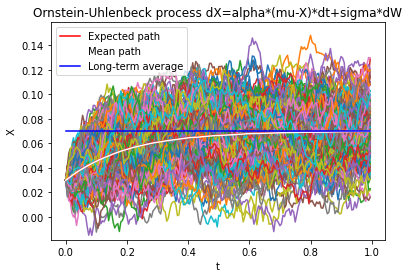

In [3]:
#Expected, mean and sample paths, long-term average
plt.figure(1)
EX = mu+(X0-mu)*np.exp(-alpha*t) #expected path
df=pd.concat([pd.Series(x) for x in X], axis=1)
mean_path=df.apply(lambda row: np.mean(row),axis=1) #mean per step
for k in range(nsteps):
    plt.plot(t,X[k])
plt.plot(t,EX,color='r',label='Expected path')
plt.plot(t,mean_path,color='w',label='Mean path')
plt.plot(t,np.ones(nsteps)*mu,color='b',label='Long-term average')
sdevinfty = sigma/np.sqrt(2*alpha)
plt.ylim([mu-4*sdevinfty,mu+4*sdevinfty])
plt.xlabel('t')
plt.ylabel('X')
plt.legend()
plt.title('Ornstein-Uhlenbeck process dX=alpha*(mu-X)*dt+sigma*dW')
plt.show()

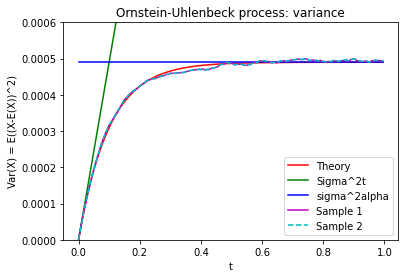

In [4]:
#Variance = mean square deviation
plt.figure(2)
ms=sigma**2/(2*alpha)*(1-np.exp(-2*alpha*t)) #variance
var_sample=sum(((X-np.array(mean_path))**2))/npaths #variance of step
df2=pd.concat([pd.Series(x) for x in ((X-EX)**2)], axis=1)
mean_diff=df2.apply(lambda row: np.mean(row),axis=1) #mean diff per step
plt.plot(t,ms,'r',t,sigma**2*t,'g',t,sigma**2/(2*alpha)*np.ones(len(t)),'b',t,var_sample,'m',t,mean_diff,'c--')
plt.legend(['Theory','Sigma^2t','sigma^2alpha','Sample 1','Sample 2'])
plt.xlabel('t')
plt.ylabel('Var(X) = E((X-E(X))^2)')
plt.ylim([0,0.0006])
plt.title('Ornstein-Uhlenbeck process: variance')
plt.show()

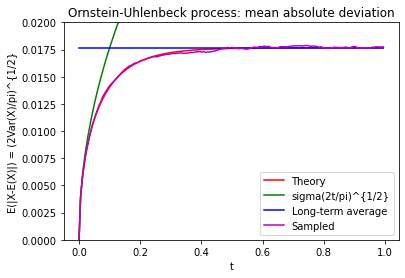

In [7]:
#Mean absolute deviation
plt.figure(3)
mss=sigma*np.sqrt((1-np.exp(-2*alpha*t))/(np.pi*alpha))
df3=pd.concat([pd.Series(x) for x in abs((X-EX))], axis=1)
mean_diff_abs=df3.apply(lambda row: np.mean(row),axis=1) #mean difference per step
plt.plot(t,mss,'r',t,sigma*np.sqrt(2*t/np.pi),'g',t,sigma/np.sqrt(np.pi*alpha)*np.ones(len(t)),'b',t,mean_diff_abs,'m')
plt.legend(['Theory','sigma(2t/pi)^{1/2}','Long-term average','Sampled'])
plt.xlabel('t')
plt.ylabel('E(|X-E(X)|) = (2Var(X)/pi)^{1/2}')
plt.ylim([0,0.02])
plt.title('Ornstein-Uhlenbeck process: mean absolute deviation')
plt.show()

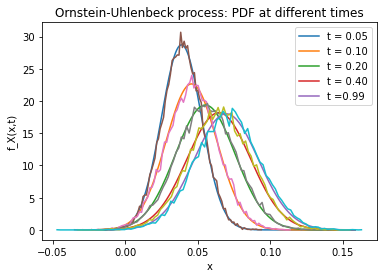

In [8]:
#Probability density functino at different times
x=np.linspace(-0.02,mu+4*sdevinfty,200)
t2 = [0.05,0.1,0.2,0.4,0.99]
EX2 = np.zeros(len(t2))
for l in range(len(t2)):
    EX2[l]=mu+(X0-mu)*np.exp(-alpha*t2[l])
sdev2=np.zeros(len(t2))
for o in range(len(t2)):
    sdev2[o]= sigma*np.sqrt((1-np.exp(-2*alpha*t2[o]))/(2*alpha))
fa = [np.zeros(len(t2))]*len(x)
fs = [np.zeros(len(t2))]*len(x)
for p in range(len(t2)):
    fa[p]=norm.pdf(x,EX2[p],sdev2[p])
plt.figure(4)
for q in range(len(t2)):
    plt.plot(x,fa[q])
for r in range(len(t2)):
    #plt.hist(X[:,int(t2[its]*nsteps)],bins=100,density=True)
    hist,x_values=np.histogram(X[:,int(t2[r]*nsteps)],bins=100,density=True)
    plt.plot(x_values[1:],hist)
plt.title('Ornstein-Uhlenbeck process: PDF at different times')
plt.xlabel('x')
plt.ylabel('f_X(x,t)')
plt.legend(['t = 0.05','t = 0.10','t = 0.20','t = 0.40','t =0.99'])
plt.show()

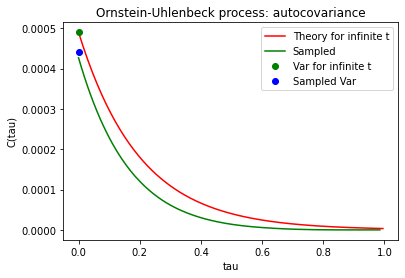

In [9]:
#Autocovariance
C=[np.zeros(len(x)*2-1)]*npaths
for tez in range(npaths):
    C[tez]=(1/len(x))*np.correlate(X[tez]-EX,X[tez]-EX,mode=2)
#replicate unbiased xcorr
df5=pd.concat([pd.Series(x) for x in C], axis=1)
C=df5.apply(lambda row: np.mean(row),axis=1) #mean per time step across paths
plt.figure(5)
plt.plot(t,sigma**2/(2*alpha)*np.exp(-alpha*t),'r',t[0:-2],C[nsteps:-1],'g',0,sigma**2/(2*alpha),'go',0,max(C),'bo')
plt.xlabel('tau')
plt.ylabel('C(tau)')
plt.legend(['Theory for infinite t','Sampled','Var for infinite t','Sampled Var'])
plt.title('Ornstein-Uhlenbeck process: autocovariance')
plt.show()

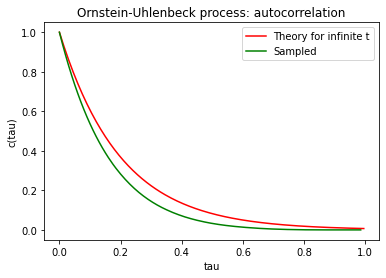

In [10]:
#Autocorrelation
plt.figure(6)
plt.plot(t,np.exp(-alpha*t),'r',t[0:-2],C[nsteps:-1]/C[nsteps],'g')
plt.xlabel('tau')
plt.ylabel('c(tau)')
plt.legend(['Theory for infinite t','Sampled'])
plt.title('Ornstein-Uhlenbeck process: autocorrelation')
plt.show()